In [1]:
# colab setup

if False:
    from google.colab import drive
    drive.mount('/content/drive/')
    path = "/content/drive/MyDrive/The-Evolution-of-Defection/"

    import sys
    sys.path.append(path)

    %pip install --ignore-installed PyYAML
    %pip install axelrod

In [2]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from copy import deepcopy
from pprint import pprint
import matplotlib.pyplot as plt


np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

import network
from axl_utils import NNplayer, State, set_match, set_play, Tournament

In [3]:
GAME_LEN = 20 + 1
C = axl.Action.C
D = axl.Action.D
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

# exponentially decaying epsilon greedy
# greedy in each iteration will be 0.35 * 0.98 ^[i] + 0.05
greedy = (0.35, 0.98, 0.05)

headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')

# Attempt 1
training from scratch

In [4]:
# training loop
# similar to the one in stage 2

# again this is just a example
# actual training is performed with Stage_3_1.py

if False:
    
    # initializing
    dqn = network.DQN([
                        network.Flatten_layer(),
                        network.Linear_layer(GAME_LEN*2, 400),
                        network.Activation_layer('ReLU'),
                        network.Linear_layer(400, 200),
                        network.Activation_layer('ReLU'),
                        network.Linear_layer(200, 40),
                        network.Activation_layer('ReLU'),
                        network.Linear_layer(40, 2),
                        ],
                network.ReplayMemory(4000), gamma=0.9, greedy=0.2)
    p1 = NNplayer(dqn, State(GAME_LEN), name='DQN1')

    dqn = network.DQN([
                        network.Flatten_layer(),
                        network.Linear_layer(GAME_LEN*2, 400),
                        network.Activation_layer('ReLU'),
                        network.Linear_layer(400, 200),
                        network.Activation_layer('ReLU'),
                        network.Linear_layer(200, 40),
                        network.Activation_layer('ReLU'),
                        network.Linear_layer(40, 2),
                        ],
                network.ReplayMemory(4000), gamma=0.9, greedy=0.2)
    p2 = NNplayer(dqn, State(GAME_LEN), name='DQN2')
    del dqn
    gc.collect()

    param1 = {"lr": 3e-4, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
          'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}
    param2 = deepcopy(param1)

    tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
    results = tournament.play()
    summary = results.summarise()
    print(pd.DataFrame(map(list, summary), columns=headers).sort_values("Name"))
    
    
    # training
    [Match((p1, p2)).play() for _ in range(200)]

    ls = []
    for i in range(30):

        if i % 2 == 0:
          # test in tournament
            with p1:
                with p2:
                    p1.network.verbosity = p2.network.verbosity = False
                    tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
                    results = tournament.play()
                    summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
                    ls.append(summary)

            print(summary.loc[['DQN1','DQN2'], ['Median_score', 'Cooperation_rating']])

            # save
            with open('data/s3/tn_results.pkl', "wb") as file:
                dill.dump(ls, file)
            with open(f'data/s3/p1_{i}.pkl', "wb") as file:
                dill.dump(p1, file)
            with open(f'data/s3/p2_{i}.pkl', "wb") as file:
                dill.dump(p2, file)

        print(f'--------Iter {i}--------')
        start = time()

        # get experience
        [Match((p1, p2)).play() for _ in range(200)]

        # train
        for _ in range(8):
            p1.train(100, param1)
            p2.train(100, param2)
            param1['lr'] = param2['lr'] = param1['lr'] * 0.9
        param1['lr'] = param2['lr'] = 3e-4
        print(p1.network.loss)
        print(p2.network.loss)
        
        # dynamically adjust epsilon-greedy
        if i >= 10:
            g = (greedy[0] * greedy[1] ** i) + greedy[2]
            p1.set_greedy(g)
            p2.set_greedy(g)
        print(f"+ {time() - start:.2f} sec")

### Results 1

In [5]:
with open("data/s3/backup/p1_1_38.pkl", "rb") as file:
    p1 = dill.load(file)
    
with open("data/s3/backup/p2_1_38.pkl", "rb") as file:
    p2 = dill.load(file)
    
with open("data/s3/backup/tn_results_1.pkl", "rb") as file:
    ls = dill.load(file)
    
p1.network.greedy = p2.network.greedy = 0.0
play(p1, p2);

[(5, 0), (1, 1), (1, 1), (0, 5), (1, 1), (1, 1), (0, 5), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 22
Player 2 score = 27


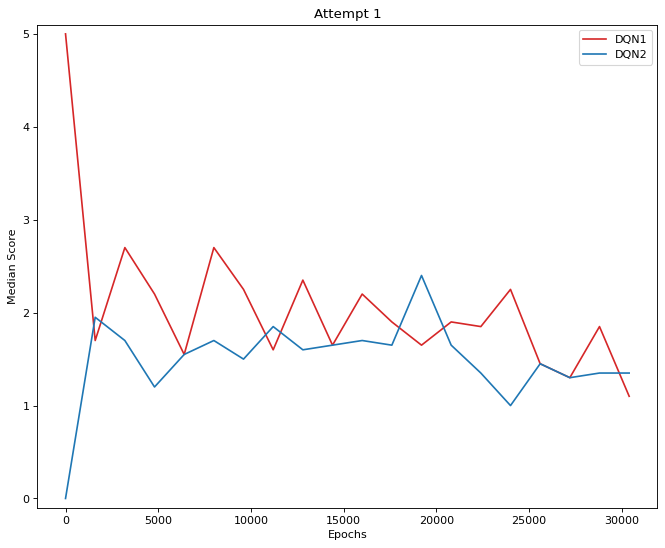

In [6]:
scores1 = pd.DataFrame([l.loc['DQN1','Median_score'] for l in ls]).to_numpy().T[0]
scores2 = pd.DataFrame([l.loc['DQN2','Median_score'] for l in ls]).to_numpy().T[0]
x_axis = range(0, 100*8*40, 100*8*2)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(x_axis, scores1, c='tab:red', label='DQN1')
plt.plot(x_axis, scores2, c='tab:blue', label='DQN2')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Median Score')
plt.title('Attempt 1')
plt.ylim([-0.1,5.1])

plt.show()

# oscillates and slowly converging to mutual defection

# Attempt 2
attempt 2 imports the trained model from stage 2

see Stage_3_2.py

### results 2

In [7]:
with open("data/s3/backup/p1_2_38.pkl", "rb") as file:
    p1 = dill.load(file)
    
with open("data/s3/backup/p2_2_38.pkl", "rb") as file:
    p2 = dill.load(file)
    
with open("data/s3/backup/tn_results_2.pkl", "rb") as file:
    ls = dill.load(file)
    
p1.network.greedy = p2.network.greedy = 0.0
play(p1, p2);

[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 20
Player 2 score = 20


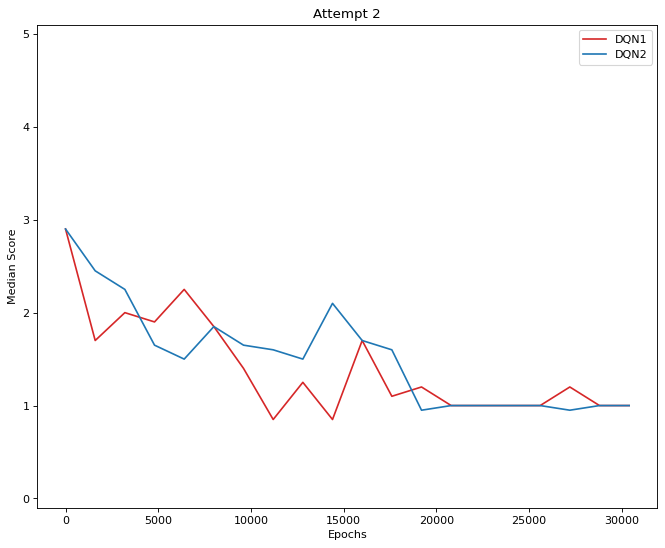

In [8]:
scores1 = pd.DataFrame([l.loc['DQN1','Median_score'] for l in ls]).to_numpy().T[0]
scores2 = pd.DataFrame([l.loc['DQN2','Median_score'] for l in ls]).to_numpy().T[0]
x_axis = range(0, 100*8*40, 100*8*2)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(x_axis, scores1, c='tab:red', label='DQN1')
plt.plot(x_axis, scores2, c='tab:blue', label='DQN2')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Median Score')
plt.title('Attempt 2')
plt.ylim([-0.1,5.1])

plt.show()

# starts from near cooperation as expected, but
# converged to mutual defection... again

In [9]:
# looking for solutions...